## LIBRERIAS

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

## CARGAMOS LA BASE DE DATOS

In [ ]:
file_='/content/drive/MyDrive/DoctoradoPaper1/DataSets/spinesv0.npz'
data = np.load(file_)
print(data['X'][:,:42,:,:].shape,data['y'].shape)

(11233, 42, 42, 3) (11233, 2)


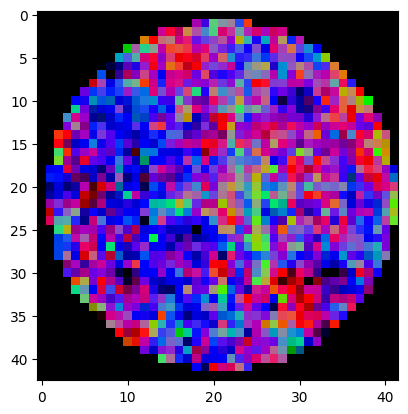

In [ ]:
plt.imshow(data['X'][700],cmap='jet')

In [ ]:
X_ = data['X'][:,:42,:,:]
Y_1 = data['y'][:,0].reshape(-1, 1)
Y_2 = data['y'][:,1].reshape(-1, 1)

In [ ]:
print(X_.shape,Y_1.shape,Y_2.shape)

NameError: name 'X_' is not defined

modificamos el dataset a los tamaños reales para ingresar al modelo

In [ ]:
def preprocess_image(image):
     image = tf.image.resize(image, (224, 224))  # Redimensionar
     #image = tf.image.grayscale_to_rgb(image)  # Convertir a 3 canales
     return image

# Crear dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(X_)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Convertir a un array numpy si es necesario
processed_images = np.array(list(dataset.as_numpy_iterator()))

In [ ]:
processed_images.shape

(11233, 224, 224, 3)

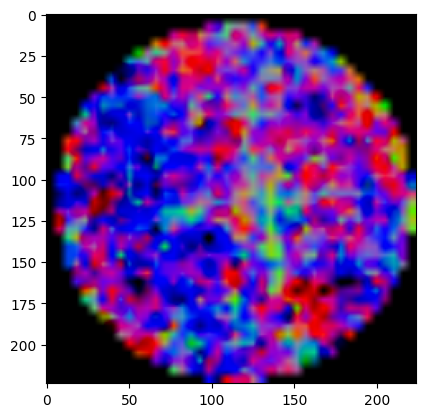

In [ ]:
plt.imshow(processed_images[700],cmap='jet')

In [ ]:
# # Crear la carpeta .kaggle si no existe
# os.makedirs("/root/.kaggle", exist_ok=True)
# # Mover el archivo kaggle.json a la carpeta
# shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
# # Dar permisos adecuados
# os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
# !kaggle datasets download -d deathperminut/material-spinners-data

Dataset URL: https://www.kaggle.com/datasets/deathperminut/material-spinners-data
License(s): CC0-1.0


In [ ]:
# # Nombre del archivo descargado (ajústalo según sea necesario)
# dataset_zip = "/content/material-spinners-data.zip"
# # Extraer los archivos
# with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
#     zip_ref.extractall("dataset")
# # Ver archivos extraídos
# os.listdir("dataset")

['data.npy.npz', '__notebook__.ipynb']

In [ ]:
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(processed_images, Y_1.reshape(-1, 1), test_size=0.2, random_state=42)
del processed_images, Y_1
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

## Y_1

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(1, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 293s 921ms/step - loss: 0.4385 - mae: 0.4097 - val_loss: 1.5977 - val_mae: 1.2448
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0326 - mae: 0.1361 - val_loss: 0.0511 - val_mae: 0.1906
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0269 - mae: 0.1228 - val_loss: 0.0381 - val_mae: 0.1608
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0206 - mae: 0.1072 - val_loss: 0.0314 - val_mae: 0.1388
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0218 - mae: 0.1118 - val_loss: 0.0696 - val_mae: 0.2191
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0146 - mae: 0.0944 - val_loss: 0.0320 - val_mae: 0.1203
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0128 - mae: 0.0874 - val_loss: 0.0371 - val_mae: 0.1255
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0109 - mae: 0.0815 - val_loss: 0.0280 - val_mae: 0.1120
Epoch 9/15
141/141 ━━━━━━━━━━━━

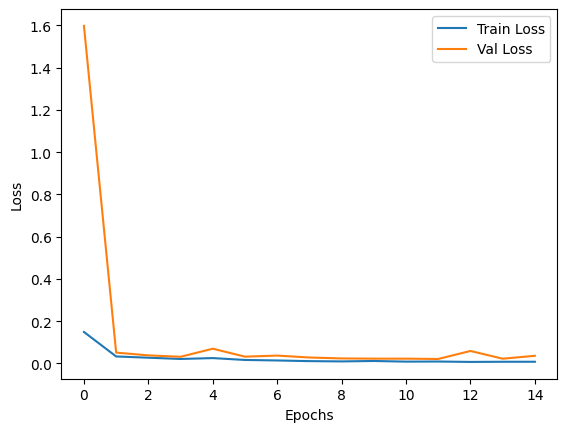

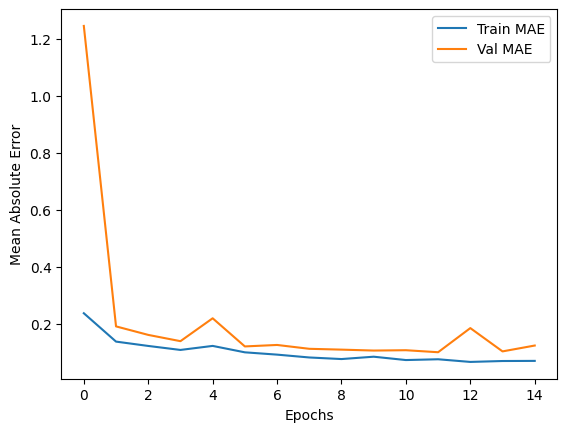

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━

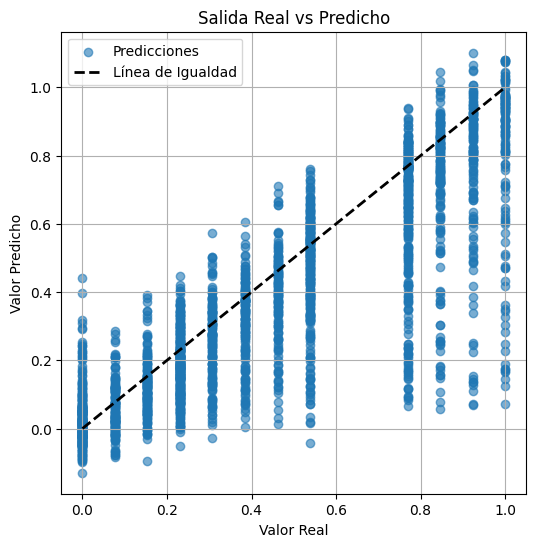

In [ ]:
# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)
y_real = np.concatenate(y_real_list, axis=0)

# Graficar predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_real[:, 0], y_pred[:, 0], alpha=0.6, label="Predicciones")
plt.plot([min(y_real[:, 0]), max(y_real[:, 0])],
         [min(y_real[:, 0]), max(y_real[:, 0])], 'k--', lw=2, label="Línea de Igualdad")  # Línea de referencia
plt.title('Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)
plt.show()

(array([2105.,  727., 1420., 1446.,  679., 1436.,    0., 1329.,  710.,
        1381.]),
 array([0.   , 0.013, 0.026, 0.039, 0.052, 0.065, 0.078, 0.091, 0.104,
        0.117, 0.13 ]),
 <BarContainer object of 10 artists>)

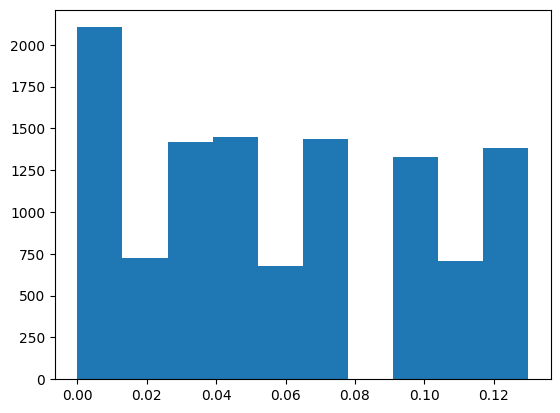

In [ ]:
plt.hist(data['y'][:,0])

In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_densenet_regresionjex2.h5')  # Guarda en formato HDF5

In [ ]:
import torch
torch.cuda.empty_cache()  # Si usas PyTorch

In [ ]:
import gc
import sys

del train_dataset, val_dataset
# Forzar recolección de basura
gc.collect()

150

## T

In [ ]:
def preprocess_image(image):
     image = tf.image.resize(image, (224, 224))  # Redimensionar
     #image = tf.image.grayscale_to_rgb(image)  # Convertir a 3 canales
     return image

# Crear dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(X_)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Convertir a un array numpy si es necesario
processed_images = np.array(list(dataset.as_numpy_iterator()))

In [ ]:
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(processed_images, Y_2.reshape(-1, 1), test_size=0.2, random_state=42)
#del MS
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(1, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 267s 831ms/step - loss: 0.3192 - mae: 0.2612 - val_loss: 2.9727 - val_mae: 1.7216
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0040 - mae: 0.0500 - val_loss: 0.0344 - val_mae: 0.1835
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0046 - mae: 0.0542 - val_loss: 0.0050 - val_mae: 0.0630
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0077 - mae: 0.0694 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0049 - mae: 0.0556 - val_loss: 8.4288e-04 - val_mae: 0.0235
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0027 - mae: 0.0419 - val_loss: 0.0059 - val_mae: 0.0722
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0049 - mae: 0.0556 - val_loss: 0.0023 - val_mae: 0.0412
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.0018 - mae: 0.0333 - val_loss: 6.3621e-04 - val_mae: 0.0198
Epoch 9/15
141/141 ━━━━

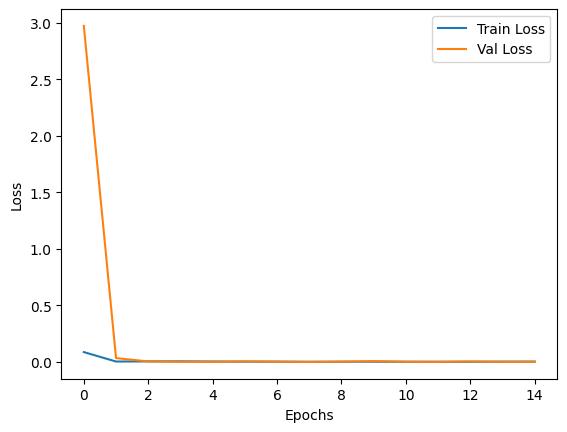

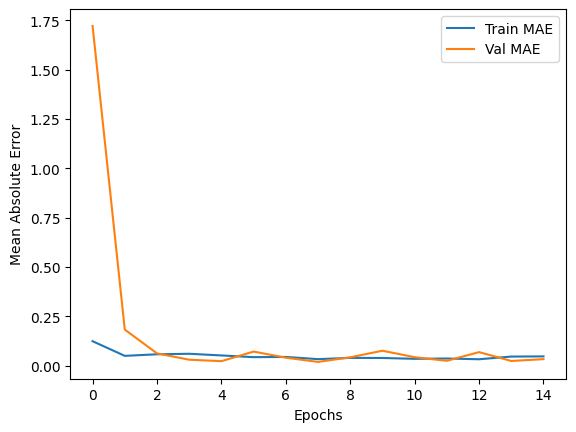

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

(array([1840., 1712., 1488., 1311., 1209., 1088.,  898.,  740.,  522.,
         425.]),
 array([ 0.1 ,  2.09,  4.08,  6.07,  8.06, 10.05, 12.04, 14.03, 16.02,
        18.01, 20.  ]),
 <BarContainer object of 10 artists>)

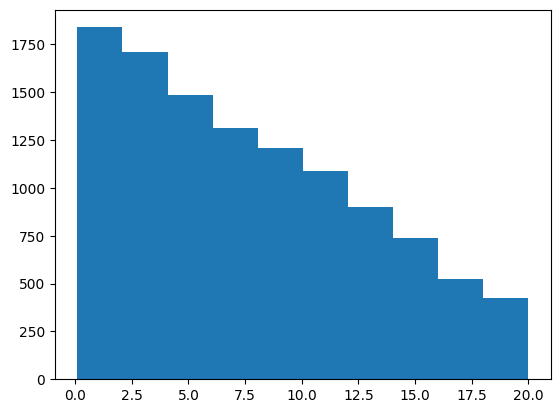

In [ ]:
plt.hist(Y_2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━

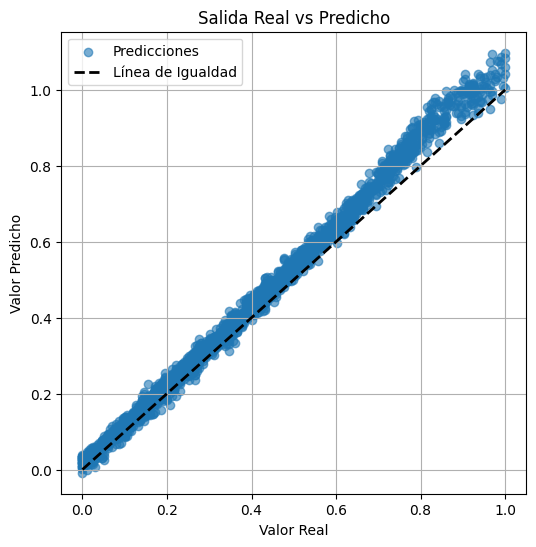

In [ ]:
# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)
y_real = np.concatenate(y_real_list, axis=0)

# Graficar predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_real[:, 0], y_pred[:, 0], alpha=0.6, label="Predicciones")
plt.plot([min(y_real[:, 0]), max(y_real[:, 0])],
         [min(y_real[:, 0]), max(y_real[:, 0])], 'k--', lw=2, label="Línea de Igualdad")  # Línea de referencia
plt.title('Salida Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_densenet_regresionY_2.h5')  # Guarda en formato HDF5

## MULTIVARIADO

In [ ]:
# Cargar nuevamente
loaded = np.load("/content/drive/MyDrive/imagenes_comprimidas.npz")
MS = loaded["data"].astype('float16')

In [ ]:
del loaded
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS,np.hstack((np.expand_dims(T, axis=-1),np.expand_dims(Jex2, axis=-1))), test_size=0.2, random_state=42)
del MS
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(2, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 6,955,906 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# Definir hiperparámetros
epochs = 15  # Número de épocas
batch_size = 64  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)


Epoch 1/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 339s 263ms/step - loss: 0.1000 - mae: 0.1452 - val_loss: 0.0155 - val_mae: 0.0985
Epoch 2/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 67s 99ms/step - loss: 0.0123 - mae: 0.0825 - val_loss: 0.0108 - val_mae: 0.0762
Epoch 3/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 66s 98ms/step - loss: 0.0117 - mae: 0.0796 - val_loss: 0.0105 - val_mae: 0.0706
Epoch 4/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 65s 96ms/step - loss: 0.0111 - mae: 0.0781 - val_loss: 0.0126 - val_mae: 0.0753
Epoch 5/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 65s 97ms/step - loss: 0.0099 - mae: 0.0732 - val_loss: 0.0150 - val_mae: 0.0988
Epoch 6/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 67s 99ms/step - loss: 0.0099 - mae: 0.0733 - val_loss: 0.1113 - val_mae: 0.2323
Epoch 7/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 66s 98ms/step - loss: 0.0096 - mae: 0.0730 - val_loss: 0.0699 - val_mae: 0.1799
Epoch 8/15
676/676 ━━━━━━━━━━━━━━━━━━━━ 66s 98ms/step - loss: 0.0095 - mae: 0.0727 - val_loss: 0.0094 - val_mae: 0.0654
Epoch 9/15
676/676 ━━━━━━━━━━━━━━━━━━━

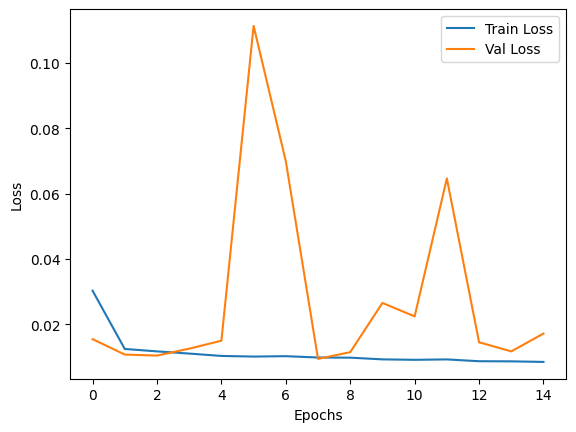

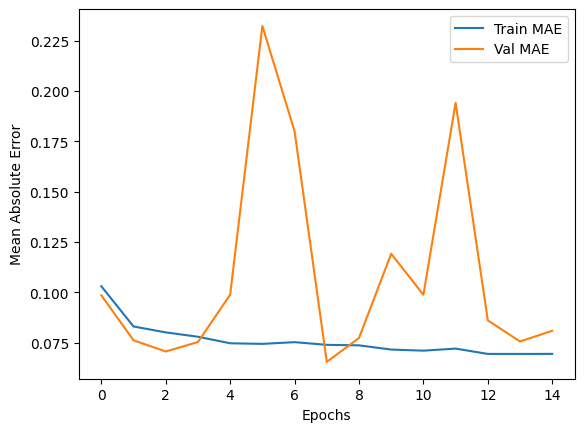

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━

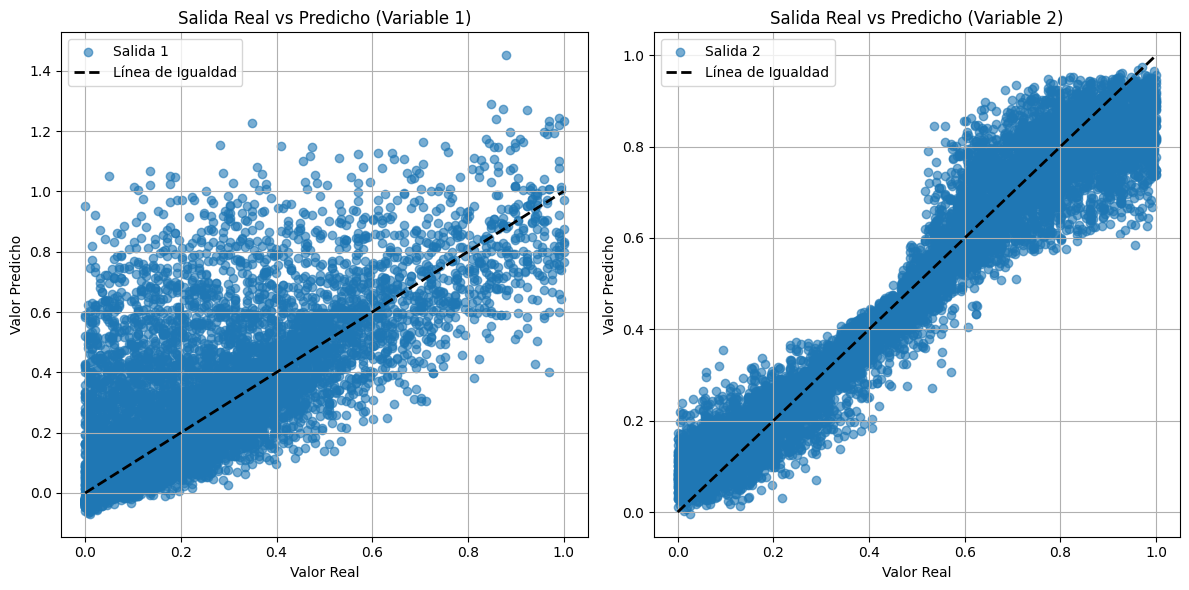

In [ ]:

# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo (ahora con 2 salidas)
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)  # (N, 2)
y_real = np.concatenate(y_real_list, axis=0)  # (N, 2)

# Graficar cada salida por separado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 2 gráficos lado a lado

for i in range(2):  # Para ambas salidas
    axes[i].scatter(y_real[:, i], y_pred[:, i], alpha=0.6, label=f'Salida {i+1}')
    axes[i].plot([min(y_real[:, i]), max(y_real[:, i])],
                 [min(y_real[:, i]), max(y_real[:, i])], 'k--', lw=2, label="Línea de Igualdad")
    axes[i].set_title(f'Salida Real vs Predicho (Variable {i+1})')
    axes[i].set_xlabel('Valor Real')
    axes[i].set_ylabel('Valor Predicho')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_densenet_regresionTJex2.h5')  # Guarda en formato HDF5